##### modeling and interpretation notebook--train, test, and conclude
***

# Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import Model Specific Libraries

In [2]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split

import math

### Reopening our cleaned dataframe

In [3]:
pd.set_option('display.max_columns', 999)  # setting to view all columns

with open('data/data-drops.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data_drops_df = pickle.load(f)

print("Dataframe successfully imported from pickle.\n\n")
display(data_drops_df.shape)
data_drops_df.head()

Dataframe successfully imported from pickle.




(19322, 16)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,98178,47.5112,-122.257,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,98125,47.7210,-122.319,1
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,98028,47.7379,-122.233,0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,98136,47.5208,-122.393,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,98074,47.6168,-122.045,0


# Questions

We have already found that some predictors could be eliminated, due to their lack of correlation or linearity with the response variable. We also eliminated some variables from our study, due to their collinearity with others.

We can begin investigating our remaining questions by building and testing a model, selecting and eliminating features, and adjusting variable coefficients along the way.

> As a reminder of our remaining basic questions:
1. ~~mean price~~
2. mean price within 20 miles of the city center
3. ~~mean bedrooms of home sales (roomates or rentals)~~
4. ~~which influences price more: the number of bedrooms or the number of square feet~~
5. ~~do renovations make a significant difference in such a competitive market~~


We may have already answered question 5, but we will let the model decide for sure.

# Correlations
### Seeing where we stand

In [4]:
# creating a correlations table
dd_corr = data_drops_df.corr()

Tthe dataframe can be visually ordered to be more useful. We can order the columns by the strength of their correlation with price, so that is what we will do.

### Sorting columns in order of correlation with `price`

In [5]:
# instantiating a sorted correlation
dd_sort_ix = dd_corr.sort_values(
    'price', ascending=False).index

# creating a variable for sorted correlation indexes
dd_sortix = data_drops_df.loc[:, dd_sort_ix]

### Viewing the sorted correlations table

In [6]:
# view without `id`
dds = dd_sortix.drop(['id'], axis=1).corr()

# view the correlations table
dds

,price,grade,sqft_living,bathrooms,lat,bedrooms,floors,Sqft_basement,view,Renovated,sqft_lot,condition,waterfront,long
price,1.000000,0.618932,0.609295,0.434373,0.413889,0.290800,0.270389,0.226851,0.200093,0.105261,0.070791,0.054149,0.024650,0.010399
grade,0.618932,1.000000,0.699486,0.613053,0.107739,0.335893,0.472663,0.057838,0.110132,0.000614,0.110850,-0.158711,0.010195,0.195652
sqft_living,0.609295,0.699486,1.000000,0.709376,0.033682,0.611205,0.366256,0.349491,0.129183,0.037033,0.202151,-0.060647,0.006378,0.250404
bathrooms,0.434373,0.613053,0.709376,1.000000,-0.000954,0.491025,0.520187,0.210283,0.071480,0.030984,0.036630,-0.130666,0.002532,0.230994
lat,0.413889,0.107739,0.033682,-0.000954,1.000000,-0.036622,0.037467,0.122920,0.015593,0.029110,-0.061206,-0.008453,-0.006727,-0.144036
bedrooms,0.290800,0.335893,0.611205,0.491025,-0.036622,1.000000,0.168740,0.272649,0.036044,0.010425,0.109847,0.028922,-0.009423,0.143168
floors,0.270389,0.472663,0.366256,0.520187,0.037467,0.168740,1.000000,-0.286285,-0.007517,-0.000451,-0.121772,-0.268026,0.000495,0.126038
Sqft_basement,0.226851,0.057838,0.349491,0.210283,0.122920,0.272649,-0.286285,1.000000,0.154804,0.049206,0.029763,0.184148,0.011890,-0.178279
view,0.200093,0.110132,0.129183,0.071480,0.015593,0.036044,-0.007517,0.154804,1.000000,0.038026,0.024076,0.035759,0.058646,-0.080293
Renovated,0.105261,0.000614,0.037033,0.030984,0.029110,0.010425,-0.000451,0.049206,0.038026,1.000000,0.006567,-0.055597,0.021866,-0.057528


We can easily see by column location that `grade` is most strongly correlated with price, followed by `sqft_living`. The weakest correlation to price and the furthest column is longitude, followed by `waterfront`. We can inspect this visually as a heatmap.

In [7]:
# create a function to generate a heatmap
def plot_corr_heatmap(cor, cmap="BuPu"):
    # creating a figure to plot a heatmap from correlations
    plt.figure(figsize=(21,18))
    sns.set(font_scale=1.5, color_codes=True) # making annotations legible
    # plotting by absolute value
    sns.heatmap(cor.round(2).abs(), center=.8, annot=True, cmap="YlGnBu")
    plt.tick_params(axis="both", which="both", bottom=False, top=True,    
                labelbottom=False, labeltop=True,left=True, 
                    right=False, labelleft=True)
    plt.xticks(rotation = 70, fontsize=20)
    plt.yticks(fontsize=20)
    plt.autoscale() # prevent cropping
    plt.show()

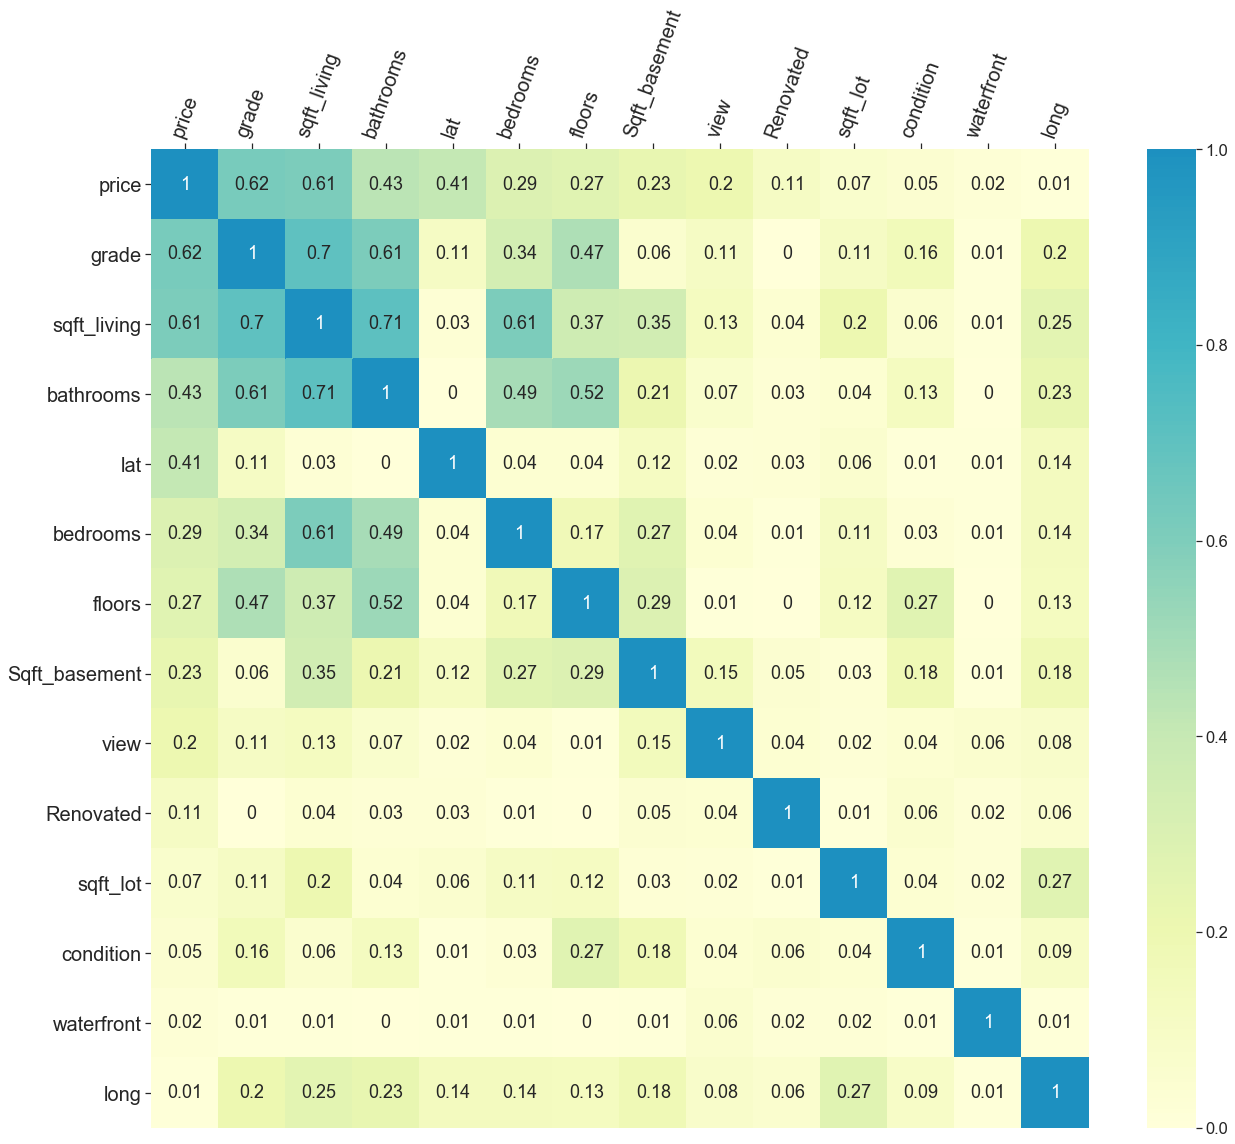

In [8]:
# displaying the heatmap
plot_corr_heatmap(dds)

This is a fairly clear indicator that `grade` and `sqft_living` are strong predictors. We also note, however, that the two appear to be strongly collinear. In addition, each appears to be strongly collinear with `bathrooms`, the next strongest feature.

# Instinct

> My instinct is that zipcode is important ('location, location, location'), and that combining it with 'sqft_living' or 'grade' will be definitive. However, I do want to test other features to see whether they reveal any unexpected value.

## Modeling Instinct

Let's go ahead and build a naive model based on our first impression.

In [9]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = ['sqft_living', 'zipcode']
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_drops_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     932.3
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:59:40   Log-Likelihood:            -2.5284e+05
No. Observations:               19322   AIC:                         5.058e+05
Df Residuals:                   19251   BIC:                         5.064e+05
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -7.116e+04   6704.008    -10.615      0.000   -8.43e+04    -5.8e+04
zipcode[T.98002]  5123.1077   1.04e+04      0.491      0.624   -1.53e+04    2.56e+04
zipcode[T.98003]  1.081e+04   9513.663      1.136      0.256   -7835.652    2.95e+04
zipcode[T.98004]  6.882e+05   9969.532     69.035      0.000    6.69e+05    7.08e+05
zipcode[T.98005]  3.712e+05   1.18e+04     31.538      0.000    3.48e+05    3.94e+05
zipcode[T.98006]  3.034e+05   8801.679     34.468      0.000    2.86e+05    3.21e+05
zipcode[T.98007]  2.827e+05   1.19e+04     23.798      0.000    2.59e+05    3.06e+05
zipcode[T.98008]  2.554e+05   9629.935     26.523      0.000    2.37e+05    2.74e+05
zipcode[T.98010]  9.006e+04   1.48e+04      6.089      0.000    6.11e+04    1.19e+05
zipcode[T.98011]  1.457e+05   1.07e+04     13.671      0.000    1.25e+05    1.67e+05
zipcode[T.98014]  1.221e+05   1.48e+04      8.252      0.000    9.31e+04    1.51e+05
zipcode[T.98019]  8.264e+04   1.12e+04      7.403      0.000    6.08e+04    1.05e+05
zipcode[T.98022]  2.833e+04    1.1e+04      2.570      0.010    6721.826    4.99e+04
zipcode[T.98023] -1.369e+04   8224.774     -1.665      0.096   -2.98e+04    2429.706
zipcode[T.98024]  1.488e+05   1.95e+04      7.627      0.000    1.11e+05    1.87e+05
zipcode[T.98027]  2.153e+05   9136.903     23.560      0.000    1.97e+05    2.33e+05
zipcode[T.98028]  1.337e+05   9477.511     14.110      0.000    1.15e+05    1.52e+05
zipcode[T.98029]  2.485e+05   9163.310     27.119      0.000    2.31e+05    2.66e+05
zipcode[T.98030]  3191.7514   9707.781      0.329      0.742   -1.58e+04    2.22e+04
zipcode[T.98031]  1.504e+04   9503.544      1.582      0.114   -3591.072    3.37e+04
zipcode[T.98032]  4226.0673   1.23e+04      0.344      0.731   -1.99e+04    2.83e+04
zipcode[T.98033]  3.717e+05   8665.041     42.896      0.000    3.55e+05    3.89e+05
zipcode[T.98034]   1.92e+05   8115.500     23.652      0.000    1.76e+05    2.08e+05
zipcode[T.98038]  2.739e+04   8091.977      3.385      0.001    1.15e+04    4.33e+04
zipcode[T.98039]   9.81e+05   2.52e+04     38.980      0.000    9.32e+05    1.03e+06
zipcode[T.98040]  5.425e+05   1.04e+04     51.935      0.000    5.22e+05    5.63e+05
zipcode[T.98042]  1.239e+04   8112.694      1.527      0.127   -3515.697    2.83e+04
zipcode[T.98045]  1.164e+05   1.07e+04     10.856      0.000    9.54e+04    1.37e+05
zipcode[T.98052]  2.735e+05   8036.981     34.032      0.000    2.58e+05    2.89e+05
zipcode[T.98053]  2.464e+05   9144.052     26.948      0.000    2.28e+05    2.64e+05
zipcode[T.98055]  4.472e+04   9576.617      4.670      0.000     2.6e+04    6.35e+04
zipcode[T.98056]  1.063e+05   8614.897     12.342      0.000    8.94e+04    1.23e+05
zipcode[T.98058]  4.175e+04   8428.437      4.954      0.000    2.52e+04    5.83e+04
zipcode[T.98059]  9.655

The ols model's R-squared suggests that 77.2\% of the variance in `price` can be explained by our model. Only 3 zipcodes have p - values above .05.

> But, wait.
* The warning indicates strong multicollinearity.
* We have a skew of 1.894. We want it to be near zero.
* Kurtosis measures 19.168. We want it near 3.

In addition, zipcode is a categorical value, but let's play this out.

## Regression Plots

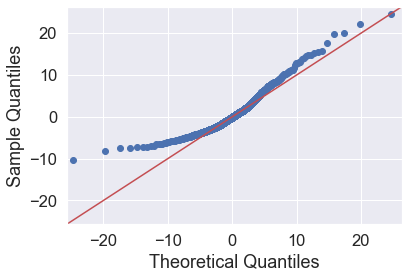

In [10]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

We see residuals far from the line, in lower quantiles. Still, this gives us something of a baseline.

# Log - transforming Continuous Variables

Let's transform our variables to see if we can get residuals into a more normal shape.

In [11]:
# Create a copy of the dataframe to log transform `sqft_living`
data_log_df = data_drops_df.copy()

### Creating a function for log - transformation

In [12]:
# log transforming continuous variables
def log_continuous(df, cols):
    for col in cols:
        df[col] = np.log(df[col])
    return df

#### Running the function on `data_log_df`

In [13]:
# transform columns in `data_log_df`
data_log_df = log_continuous(data_log_df, ['price', 'sqft_living', 'condition', 'grade'])

# view first rows
data_log_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,Sqft_basement,zipcode,lat,long,Renovated
0,7129300520,12.309982,3,1.00,7.073270,5650,1.0,0,0,1.098612,1.945910,0,98178,47.5112,-122.257,0
1,6414100192,13.195614,3,2.25,7.851661,7242,2.0,0,0,1.098612,1.945910,400,98125,47.7210,-122.319,1
2,5631500400,12.100712,2,1.00,6.646391,10000,1.0,0,0,1.098612,1.791759,0,98028,47.7379,-122.233,0
3,2487200875,13.311329,4,3.00,7.580700,5000,1.0,0,0,1.609438,1.945910,910,98136,47.5208,-122.393,0
4,1954400510,13.142166,3,2.00,7.426549,8080,1.0,0,0,1.098612,2.079442,0,98074,47.6168,-122.045,0


We will also need to convert `Sqft_basement` to simply reflect whether or not the property has a basement, in the same way we did for `Renovated`.

In [14]:
# creating a new boolean column
# returning True for `Sqft_basement` > 1 in each row
data_log_df['Basement'] = (data_log_df['Sqft_basement'].round() > 1).astype('int64')
data_log_df.drop(columns='Sqft_basement', inplace=True)

# inspecting dataframe with new `Renovated` column
data_log_df.head(1)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,Renovated,Basement
0,7129300520,12.309982,3,1.0,7.07327,5650,1.0,0,0,1.098612,1.94591,98178,47.5112,-122.257,0,0


### Re - running our Model with Transformed Values

In [15]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = ['sqft_living', 'zipcode']
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     1235.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:59:43   Log-Likelihood:                 3743.7
No. Observations:               19322   AIC:                            -7345.
Df Residuals:                   19251   BIC:                            -6787.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.5775      0.032    233.486      0.000       7.514       7.641
zipcode[T.98002]    -0.0476      0.018     -2.667      0.008      -0.083      -0.013
zipcode[T.98003]     0.0370      0.016      2.272      0.023       0.005       0.069
zipcode[T.98004]     1.1984      0.017     70.340      0.000       1.165       1.232
zipcode[T.98005]     0.8451      0.020     42.005      0.000       0.806       0.885
zipcode[T.98006]     0.7371      0.015     49.015      0.000       0.708       0.767
zipcode[T.98007]     0.7091      0.020     34.911      0.000       0.669       0.749
zipcode[T.98008]     0.6744      0.016     40.962      0.000       0.642       0.707
zipcode[T.98010]     0.2683      0.025     10.609      0.000       0.219       0.318
zipcode[T.98011]     0.4723      0.018     25.929      0.000       0.437       0.508
zipcode[T.98014]     0.3391      0.025     13.409      0.000       0.290       0.389
zipcode[T.98019]     0.3209      0.019     16.813      0.000       0.283       0.358
zipcode[T.98022]     0.0674      0.019      3.577      0.000       0.030       0.104
zipcode[T.98023]    -0.0116      0.014     -0.824      0.410      -0.039       0.016
zipcode[T.98024]     0.4307      0.033     12.915      0.000       0.365       0.496
zipcode[T.98027]     0.6001      0.016     38.429      0.000       0.569       0.631
zipcode[T.98028]     0.4298      0.016     26.524      0.000       0.398       0.462
zipcode[T.98029]     0.6597      0.016     42.112      0.000       0.629       0.690
zipcode[T.98030]     0.0486      0.017      2.926      0.003       0.016       0.081
zipcode[T.98031]     0.0782      0.016      4.810      0.000       0.046       0.110
zipcode[T.98032]    -0.0197      0.021     -0.935      0.350      -0.061       0.022
zipcode[T.98033]     0.8349      0.015     56.379      0.000       0.806       0.864
zipcode[T.98034]     0.5388      0.014     38.830      0.000       0.512       0.566
zipcode[T.98038]     0.1586      0.014     11.464      0.000       0.131       0.186
zipcode[T.98039]     1.4217      0.043     33.049      0.000       1.337       1.506
zipcode[T.98040]     1.0318      0.018     57.846      0.000       0.997       1.067
zipcode[T.98042]     0.0769      0.014      5.547      0.000       0.050       0.104
zipcode[T.98045]     0.3633      0.018     19.816      0.000       0.327       0.399
zipcode[T.98052]     0.7010      0.014     51.032      0.000       0.674       0.728
zipcode[T.98053]     0.6576      0.016     42.079      0.000       0.627       0.688
zipcode[T.98055]     0.1373      0.016      8.388      0.000       0.105       0.169
zipcode[T.98056]     0.3401      0.015     23.090      0.000       0.311       0.369
zipcode[T.98058]     0.1783      0.014     12.375      0.000       0.150       0.207
zipcode[T.98059]     0.

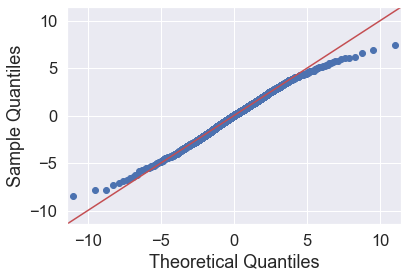

In [16]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

We see improvement in the model. We should go further to ensure that features are being evaluated on a similar scale, which we can do using min / max scaling. We can achieve this by applying the following formula: x - min(x) / (max(x) - min(x))

In [17]:
'''A function to scale column values passed as a list of cols
'''
def scale_df(df, cols):
    for col in cols:
        df[col] = (df[col] - min(df[col]))/(max(df[col]) - min(df[col]))
    return df

# Scaling Data

In [18]:
# list the numeric columns
numer_list = list(data_log_df.select_dtypes(
    include=[np.number]).columns.values)

numer_list

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'lat',
 'long',
 'Renovated',
 'Basement']

In [19]:
# removing id from the list
numer_list.pop(0)

'id'

In [20]:
# scale columns in `data_log_df`
data_log_df = scale_df(data_log_df, numer_list)

# view first rows
data_log_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,Renovated,Basement
0,7129300520,0.287795,0.4,0.133333,0.460169,0.039413,0.0,0.0,0.0,0.682606,0.611196,98178,0.571498,0.206403,0.0,0.0
1,6414100192,0.531580,0.4,0.466667,0.769016,0.051644,0.5,0.0,0.0,0.682606,0.611196,98125,0.908959,0.154170,1.0,1.0
2,5631500400,0.230191,0.2,0.133333,0.290793,0.072833,0.0,0.0,0.0,0.682606,0.500000,98028,0.936143,0.226622,0.0,0.0
3,2487200875,0.563432,0.6,0.666667,0.661505,0.034419,0.0,0.0,0.0,1.000000,0.611196,98136,0.586939,0.091828,0.0,1.0
4,1954400510,0.516867,0.4,0.400000,0.600342,0.058082,0.0,0.0,0.0,0.682606,0.707519,98074,0.741354,0.385004,0.0,0.0


We'll try this without `zipcode`.

In [21]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = ['sqft_living']
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                 1.088e+04
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:59:46   Log-Likelihood:                 16531.
No. Observations:               19322   AIC:                        -3.306e+04
Df Residuals:                   19320   BIC:                        -3.304e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1545      0.003     49.426      0.000       0.148       0.161
sqft_living     0.5056      0.005    104.306      0.000       0.496       0.515
==============================================================================
Omnibus:                      165.989   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.767
Skew:                           0.033   Prob(JB):                     8.86e-25
Kurtosis:                       2.635   Cond. No.                         9.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That is a positive change to skew and krutosis (and condition number).

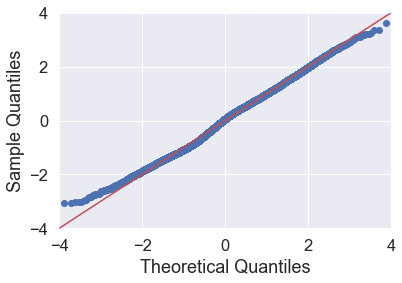

In [22]:
# viewing q-q plot of residuals
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

I wonder what we can do in a model with all numerical predictors from our `numer_list`. First, we have to remove `price` from the list.

In [23]:
# remove price from the list of numeric variables
numer_list.pop(0)

'price'

# Numeric Model

In [24]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = numer_list
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     3236.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:59:49   Log-Likelihood:                 23389.
No. Observations:               19322   AIC:                        -4.675e+04
Df Residuals:                   19308   BIC:                        -4.664e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2713      0.006    -47.629      0.000      -0.282      -0.260
bedrooms       -0.0300      0.004     -7.356      0.000      -0.038      -0.022
bathrooms       0.0042      0.005      0.904      0.366      -0.005       0.013
sqft_living     0.3095      0.007     45.731      0.000       0.296       0.323
sqft_lot        0.0069      0.007      0.937      0.349      -0.008       0.021
floors          0.0180      0.003      6.781      0.000       0.013       0.023
waterfront      0.0998      0.042      2.391      0.017       0.018       0.182
view            0.0560      0.003     21.361      0.000       0.051       0.061
condition       0.1416      0.005     29.339      0.000       0.132       0.151
grade           0.4339      0.008     53.222      0.000       0.418       0.450
lat             0.2582      0.002    107.758      0.000       0.254       0.263
long           -0.0355      0.005     -6.869      0.000      -0.046      -0.025
Renovated       0.0483      0.003     15.930      0.000       0.042       0.054
Basement        0.0043      0.001      3.311      0.001       0.002       0.007
==============================================================================
Omnibus:                      560.775   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              927.015
Skew:                           0.267   Prob(JB):                    5.03e-202
Kurtosis:                       3.931   Cond. No.                         151.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking Correlation

> An Rsq of 69.1\%: not bad.
* P - values are greater than .05 for `bathrooms`, and `sqft_lot`. We will want to deal with those.
    * First, let's check correlation to get a sense of whether or not the two features are valuable.

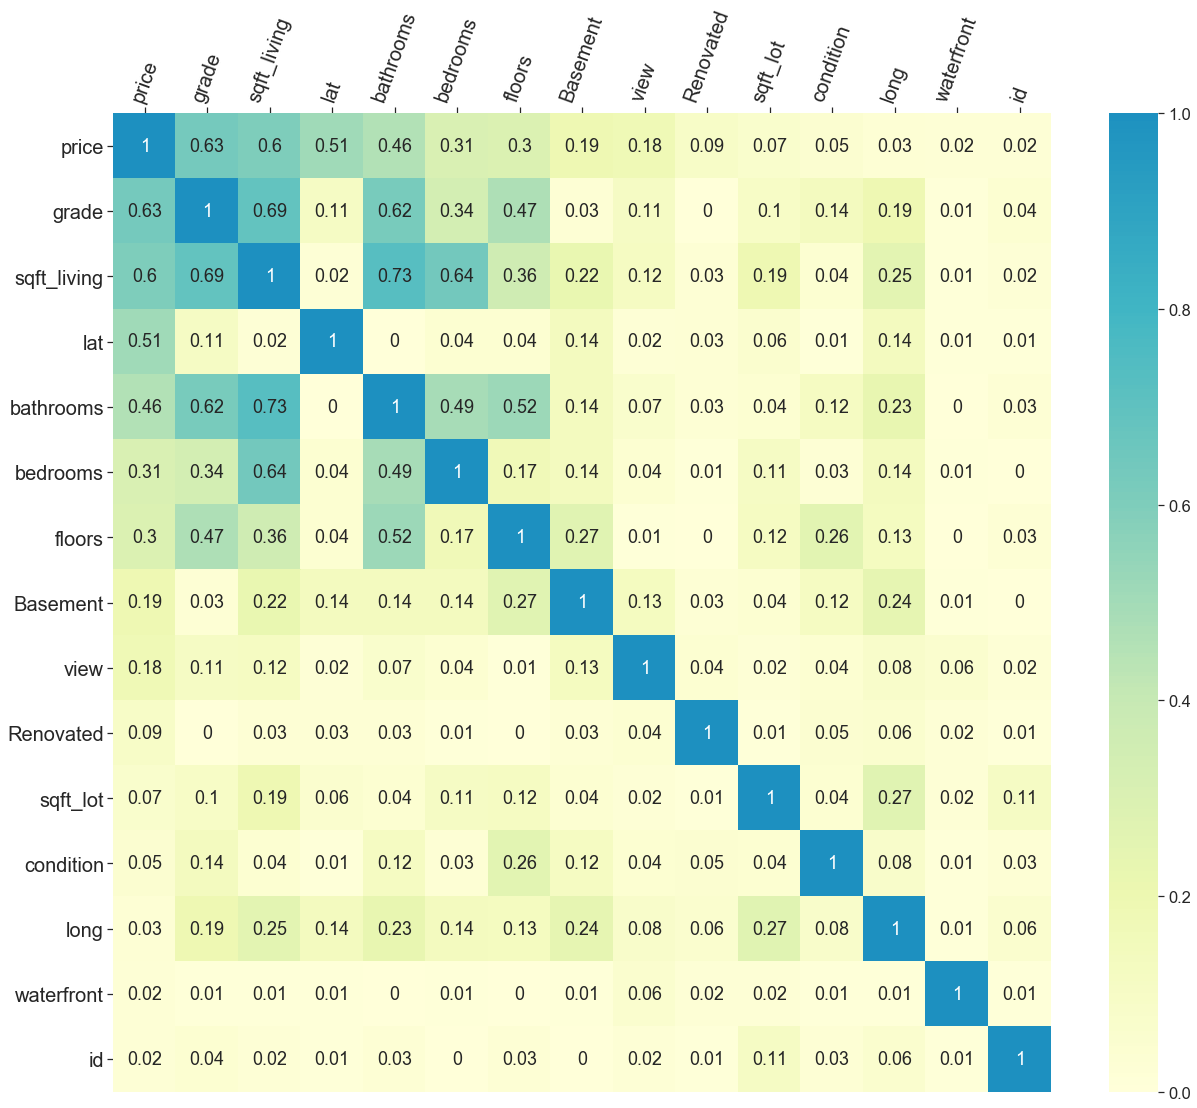

In [25]:
# instantiating a sorted correlation
dl_sort_ix = data_log_df.corr().sort_values(
    'price', ascending=False).index

dl_sortix = data_log_df.loc[:, dl_sort_ix]

# view without `id`
dls = dl_sortix.corr()

# displaying the heatmap
plot_corr_heatmap(dls)

> Well, that decides it:
* `sqft_lot` does not appear to have a particularly strong correlation with price, so we can simply remove it from our model.
* 'bathrooms' performs better, but it is collinear with the two strongest features. We can remove it, as well.

## Drop `sqft_lot` and `bathrooms`

In [26]:
# dropping both columns
data_log_df.drop(['sqft_lot', 'bathrooms'], axis=1, inplace=True)
data_log_df.head(2)

,id,price,bedrooms,sqft_living,floors,waterfront,view,condition,grade,zipcode,lat,long,Renovated,Basement
0,7129300520,0.287795,0.4,0.460169,0.0,0.0,0.0,0.682606,0.611196,98178,0.571498,0.206403,0.0,0.0
1,6414100192,0.531580,0.4,0.769016,0.5,0.0,0.0,0.682606,0.611196,98125,0.908959,0.154170,1.0,1.0


In [27]:
# remove dropped column names from our numeric list
numer_list = [item for item in numer_list 
              if item not in ['bathrooms', 'sqft_lot']]

numer_list

['bedrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'lat',
 'long',
 'Renovated',
 'Basement']

In [28]:
# set outcome ('target')
outcome = 'price'
# initialize variable for columns to submit to ols
x_cols = numer_list
# define the formula to run the inputs
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors

# name the model request and compute a summary
model = ols(formula=formula, data=data_log_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     3825.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:59:52   Log-Likelihood:                 23388.
No. Observations:               19322   AIC:                        -4.675e+04
Df Residuals:                   19310   BIC:                        -4.666e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.2722      0.006    -48.355      0.000      -0.283      -0.261
bedrooms       -0.0297      0.004     -7.331      0.000      -0.038      -0.022
sqft_living     0.3124      0.006     49.592      0.000       0.300       0.325
floors          0.0184      0.002      7.665      0.000       0.014       0.023
waterfront      0.1005      0.042      2.407      0.016       0.019       0.182
view            0.0560      0.003     21.380      0.000       0.051       0.061
condition       0.1415      0.005     29.343      0.000       0.132       0.151
grade           0.4351      0.008     54.076      0.000       0.419       0.451
lat             0.2581      0.002    107.981      0.000       0.253       0.263
long           -0.0340      0.005     -6.773      0.000      -0.044      -0.024
Renovated       0.0484      0.003     15.977      0.000       0.042       0.054
Basement        0.0044      0.001      3.495      0.000       0.002       0.007
==============================================================================
Omnibus:                      564.292   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              935.545
Skew:                           0.268   Prob(JB):                    7.06e-204
Kurtosis:                       3.936   Cond. No.                         147.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### It looks like those two features will not be missed, at all.

* Let's see if sklearn libraries indicate that the model is valid.

# Validating the Model

Let's check our model in sklearn.

In [29]:
# Run the same model in sci - kit learn
X = data_log_df[x_cols]
y = data_log_df[outcome]

linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
# coefficients
linreg.coef_

array([-0.02968868,  0.31240858,  0.01840148,  0.10049873,  0.05603804,
        0.14151876,  0.43512673,  0.25805026, -0.03398454,  0.04839512,
        0.00444616])

### The coefficients match those computed with statsmodels.


In [31]:
# intercept
linreg.intercept_

-0.27220890486985994

### The intercept matches

In [32]:
# testing on 30% of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 

In [33]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13525, 11), (5797, 11), (13525,), (5797,))

In [34]:
linreg = LinearRegression(fit_intercept=False)

In [35]:
# train the model on our test data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [36]:
# find Beta0 coefficients
linreg.coef_

array([-0.04714017,  0.35824128,  0.02643099,  0.11315379,  0.06443016,
       -0.01478452,  0.20693211,  0.23471157, -0.07581281,  0.0376699 ,
        0.00362661])

In [37]:
# get Rsq
rsq = linreg.score(X_test, y_test).round(3)

# view the sklearn R - squared score for the model
print("R - squared:", rsq)

R - squared: 0.648


## Compare Rsq Scores for Train and Test Sets

In [38]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [39]:
r2_score(y_train, y_hat_train).round(3), r2_score(y_test, y_hat_test).round(3)

(0.647, 0.648)

> sklearn train and test Rsq scores are close, indicating that the data is not over - fit. They also are consistent with the OLS model.

## Cross Fold Validation

In [40]:
# validate on 5 folds (testing 20% of data each time)
cv_linreg = cross_val_score(linreg, X, y, cv=5, scoring='r2')

# view Rsq for each fold
cv_linreg

array([0.64585593, 0.63050842, 0.63778842, 0.65448524, 0.65584064])

### Cross - val cores are still close (within .02). This indicates that we have a valid model.

***
# Reviewing Assumptions for Linear Regression

## - Linearity between target and predictor variables

#### We can view regression plots to inspect and validate linearity

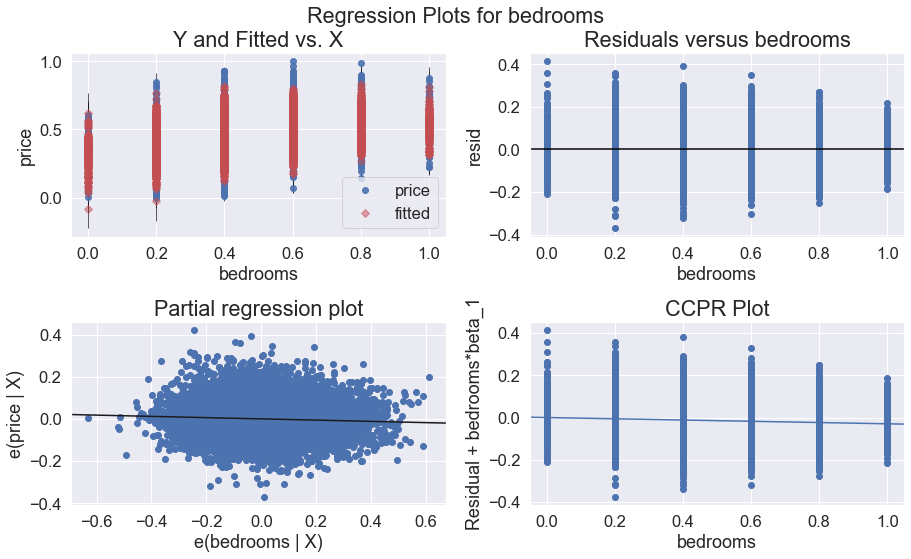

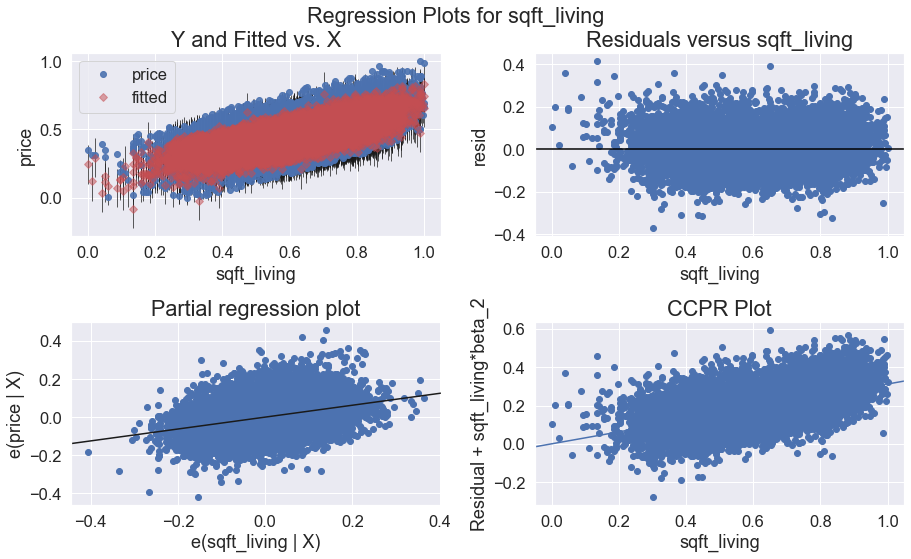

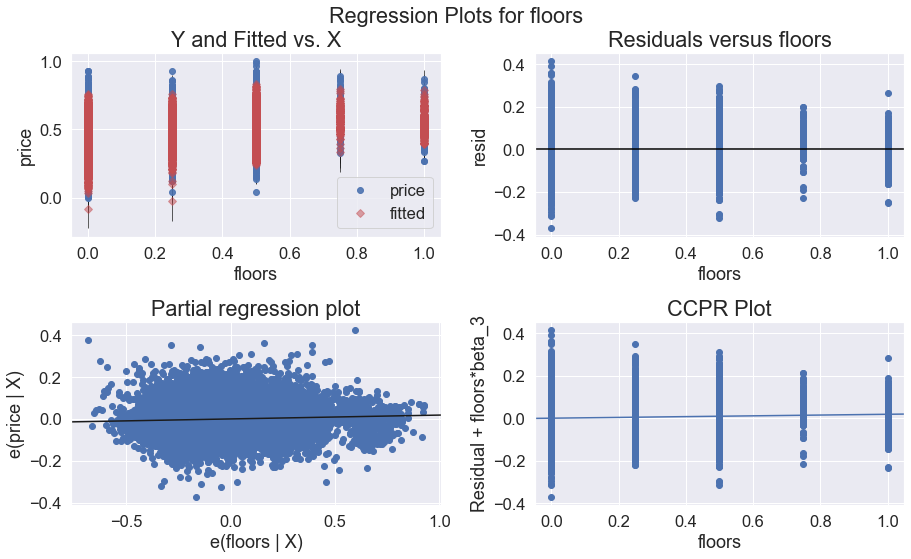

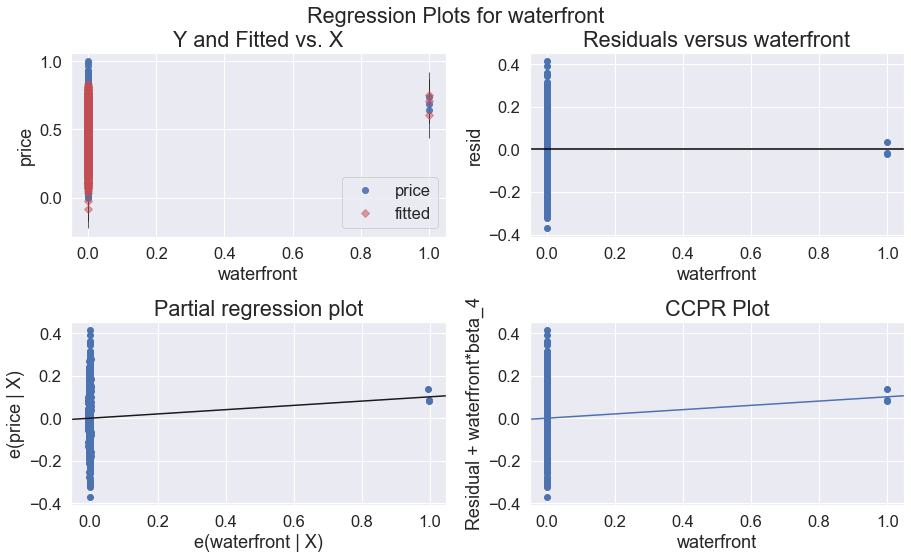

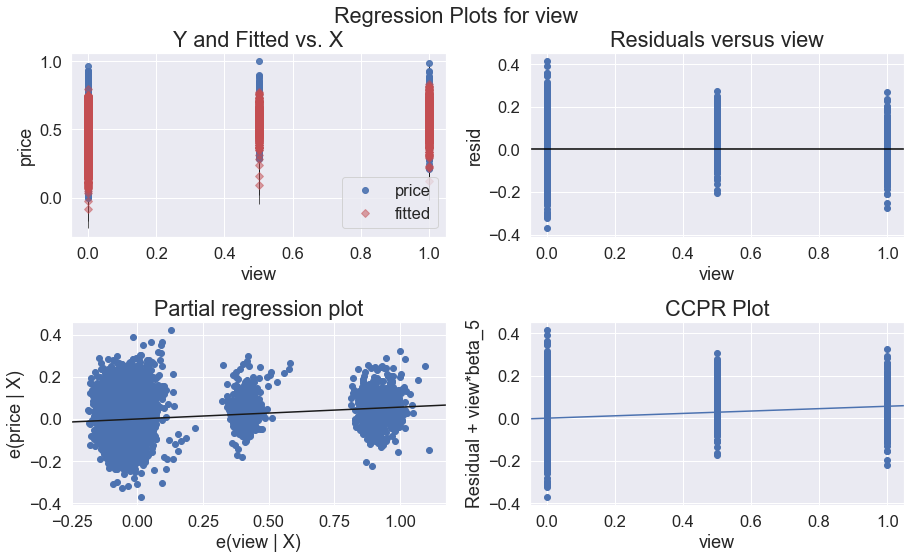

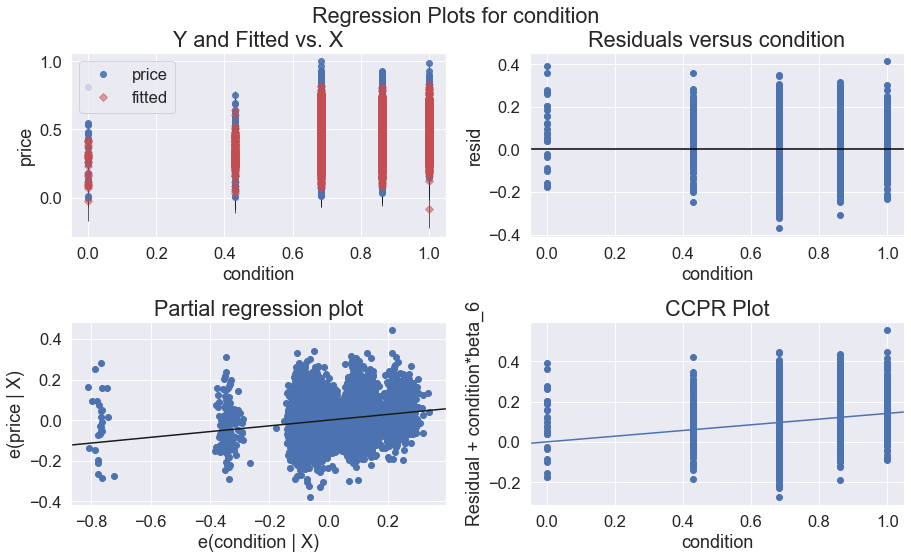

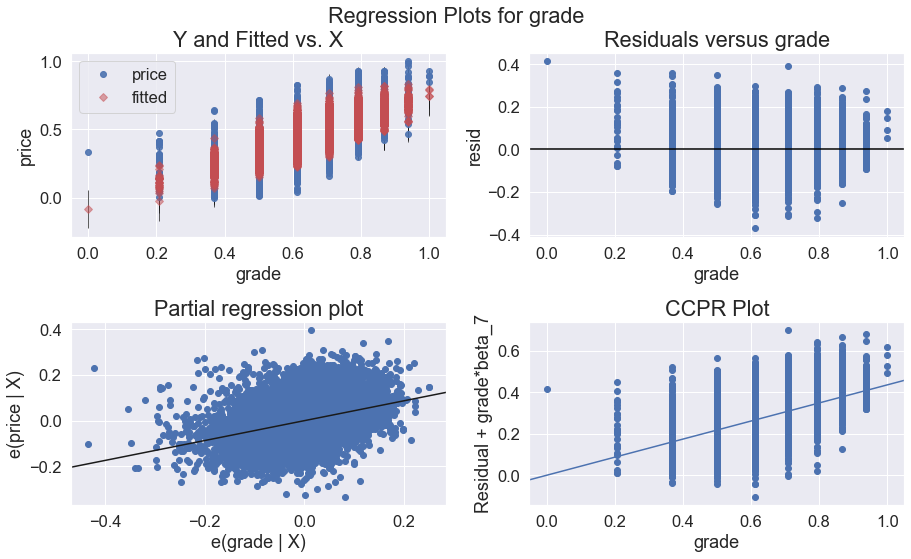

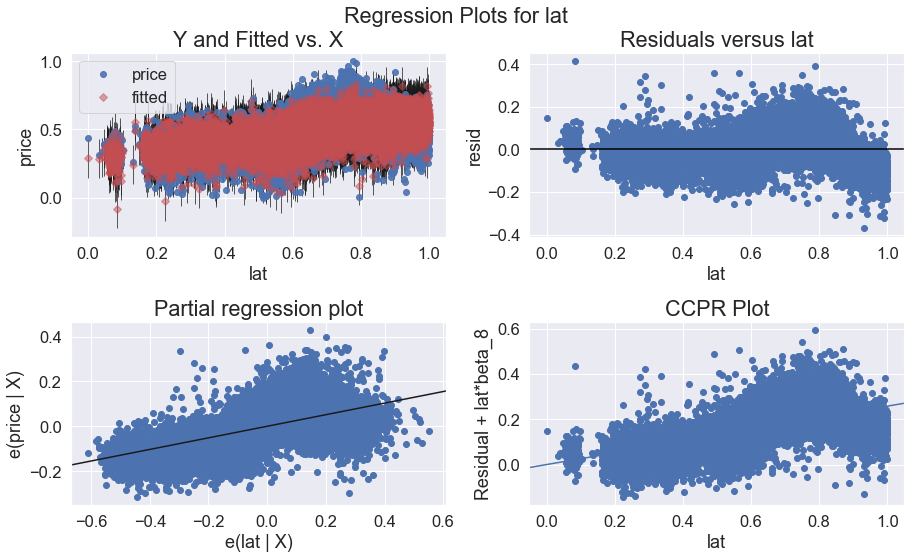

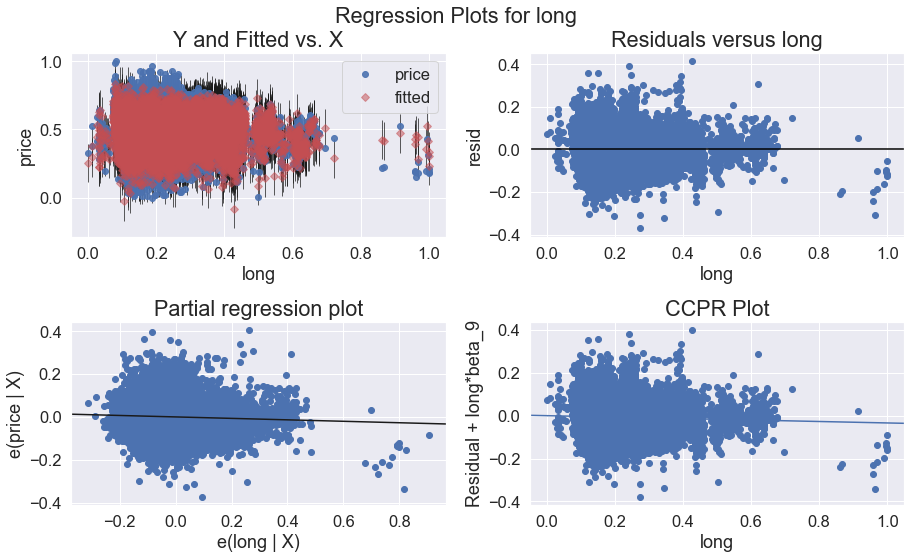

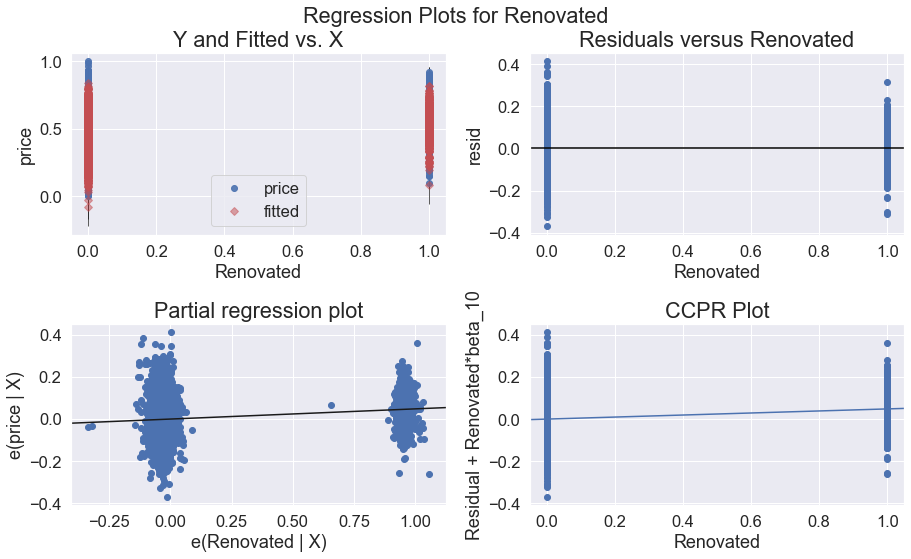

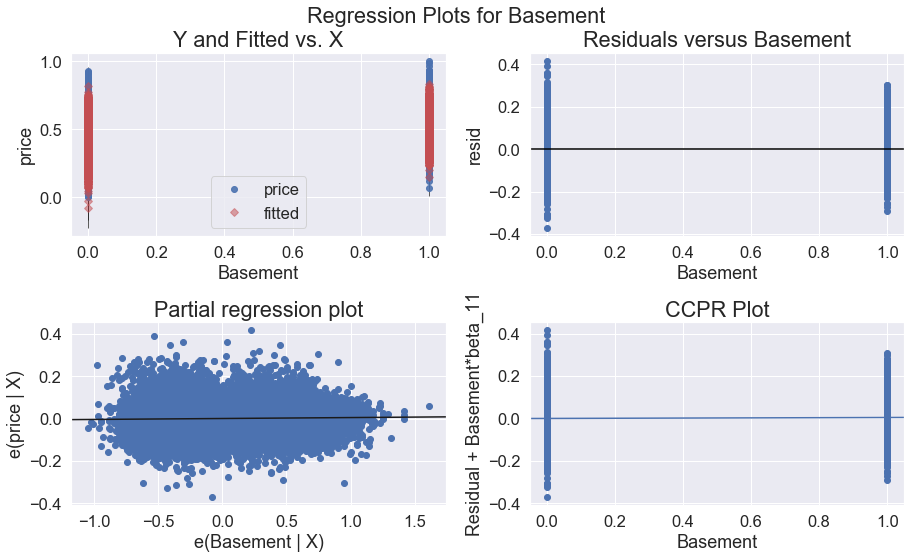

In [41]:
# viewing regression plots
for col in x_cols:
    fig = plt.figure(figsize=(13,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()
    print("="*72)

## - Normality of model residuals

#### We can view a QQ - Plot to validate the normality of residuals from our model by seeing how well sample quantiles align to test quantiles.

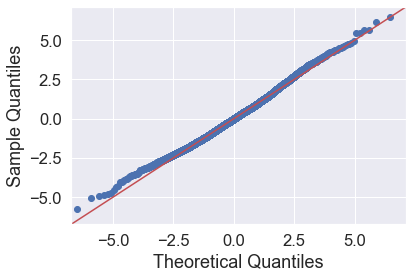

In [42]:
res = model.resid # residuals
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

#### Furthurmore, we can use visualization to confirm normality for each tested independent variable.

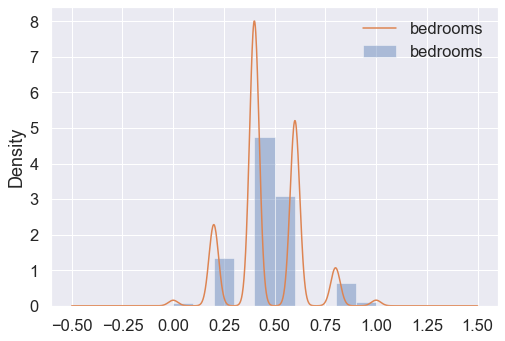

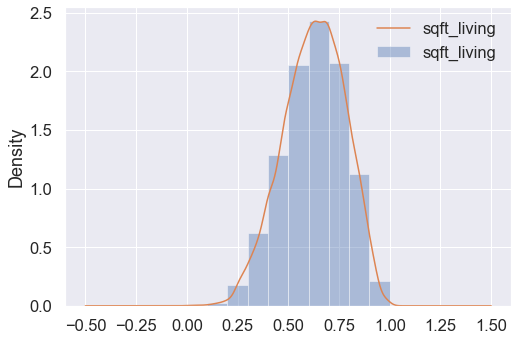

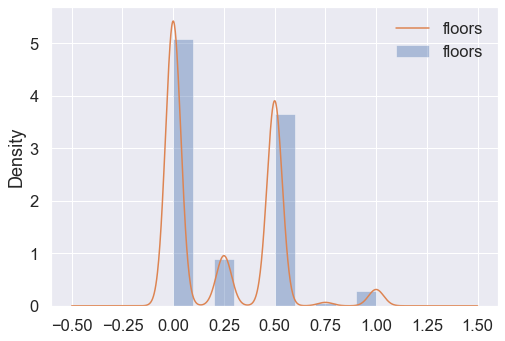

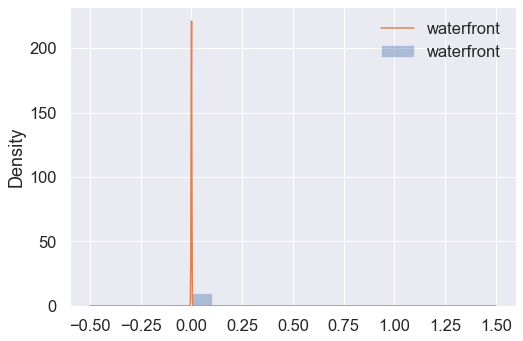

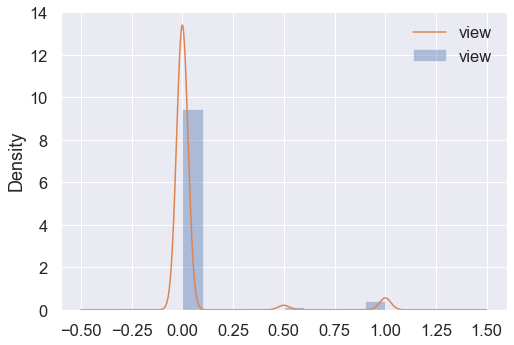

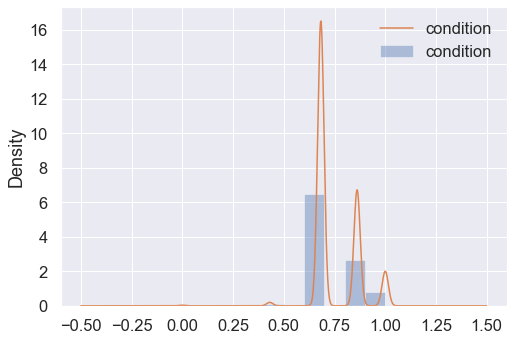

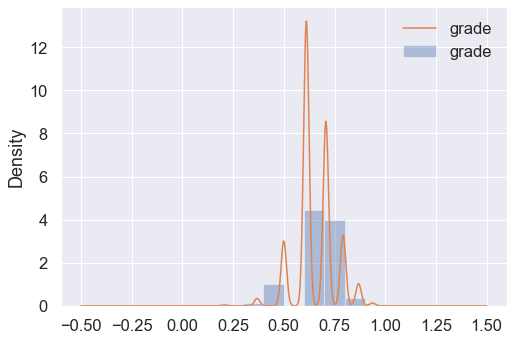

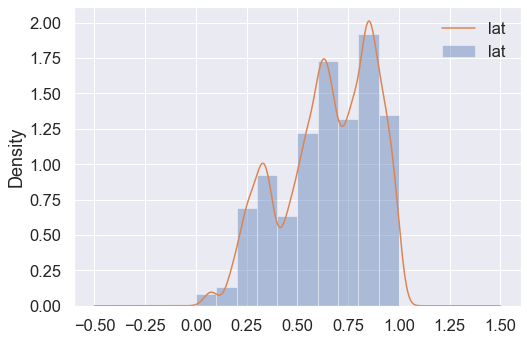

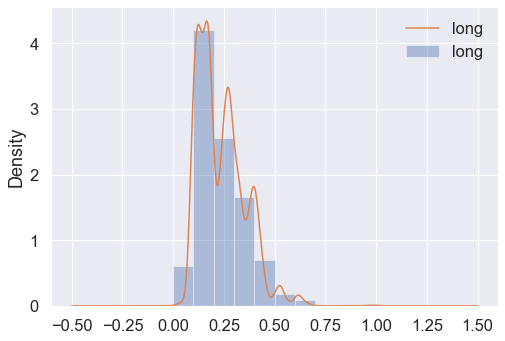

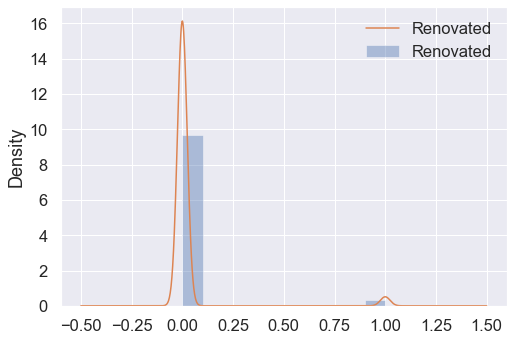

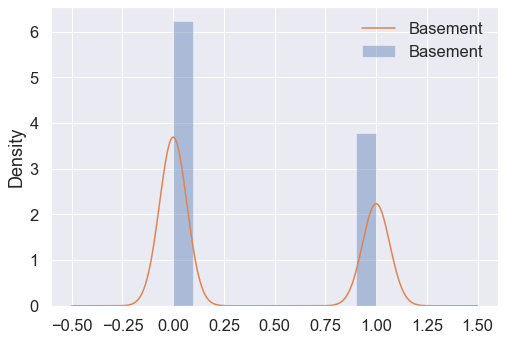

In [48]:
# plotting hist and kde for each modeled variable
for col in numer_list:
    data_log_df[col].plot.hist(density=True, alpha=.4)
    data_log_df[col].plot.kde(label=col)
    plt.legend()
    plt.show()

## - Homoscedasticity: equal variability of a dependent variable across the values of an independent variable

#### We can inspect homogeneity of variance by viewing scatterplots of our residuals and confirming apparent uniform randomness.

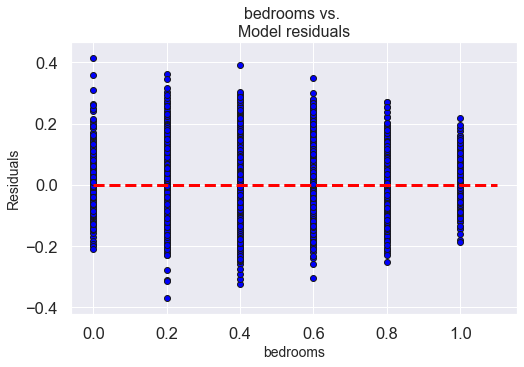

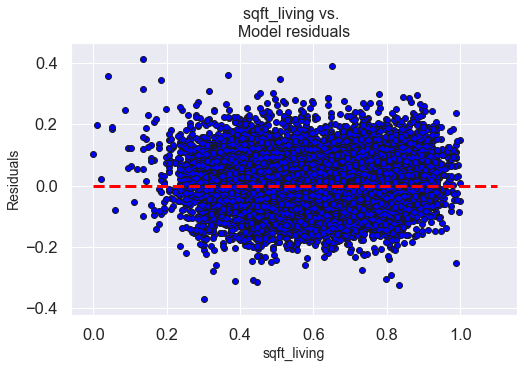

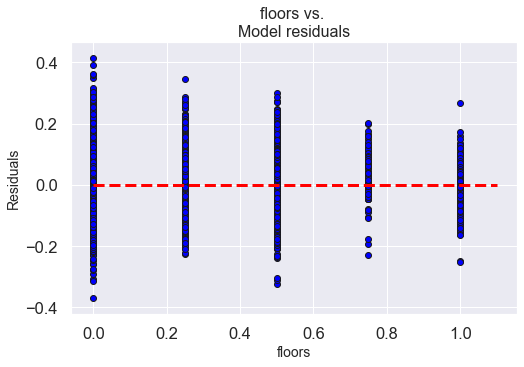

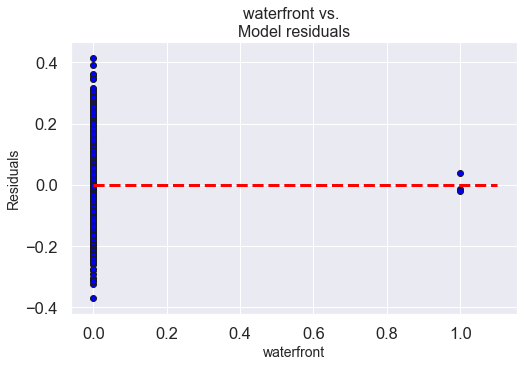

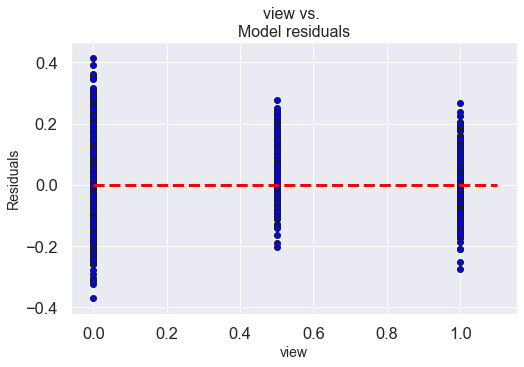

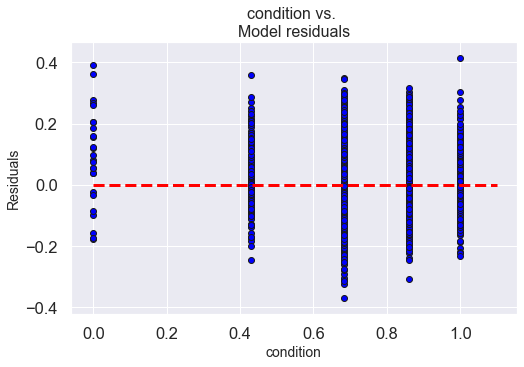

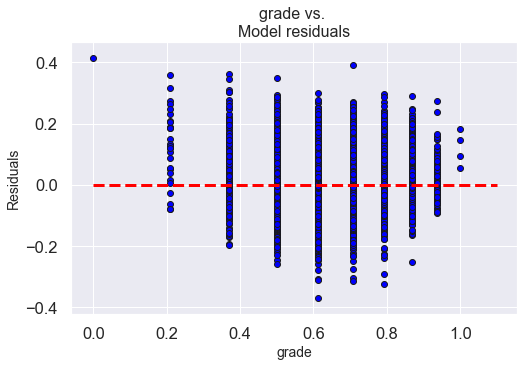

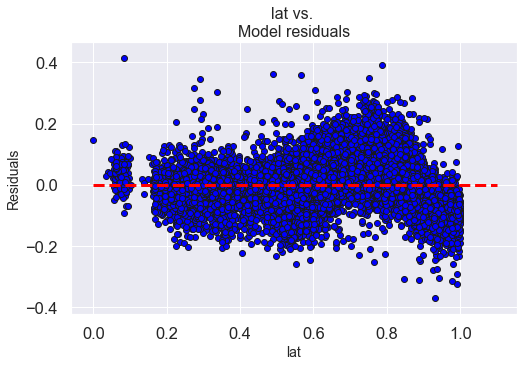

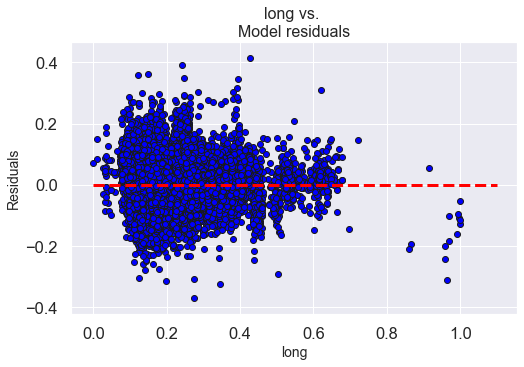

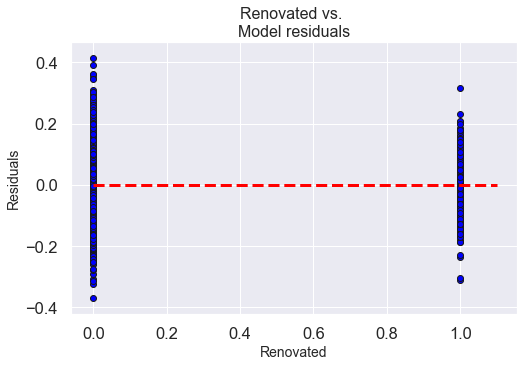

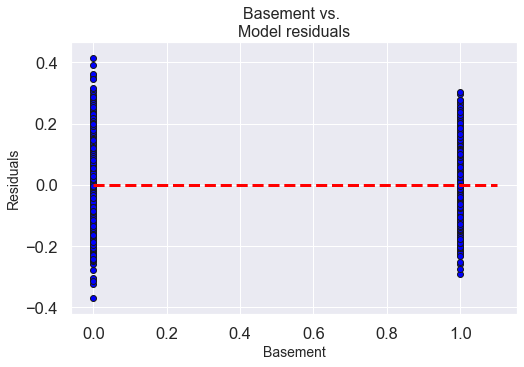

In [45]:
# instantiating a model variable for the loop
fitted = model

# view residual fit for each tested independent variable
for c in x_cols:
    plt.figure(figsize=(8,5))
    plt.title(f"{c} vs. \nModel residuals", fontsize=16)
    plt.scatter(x=data_log_df[c], y=fitted.resid, 
                color='blue', edgecolor='k')
    plt.grid(True)
    xmin=min(data_log_df[c])
    xmax = max(data_log_df[c])
    # add y=0 line across data with space from side edges
    plt.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, 
               color='red', linestyle='--', lw=3)
    plt.xlabel(c, fontsize=14)
    plt.ylabel('Residuals', fontsize=14)
    plt.show()

## - Absence of, or minimal multicollinearity

When predictor variables can predict one another, it is difficult to say with certainty which is responsible for any affect on the target variable.

As we have seen many times, throughout this project, correlation matrices are useful for identifying and quantifying relationships between variables. We most recently took advantage of this form of data visualization to reduce multicollinearity by removing `bathrooms` for its influence on both `sqft_living` and `grade`.

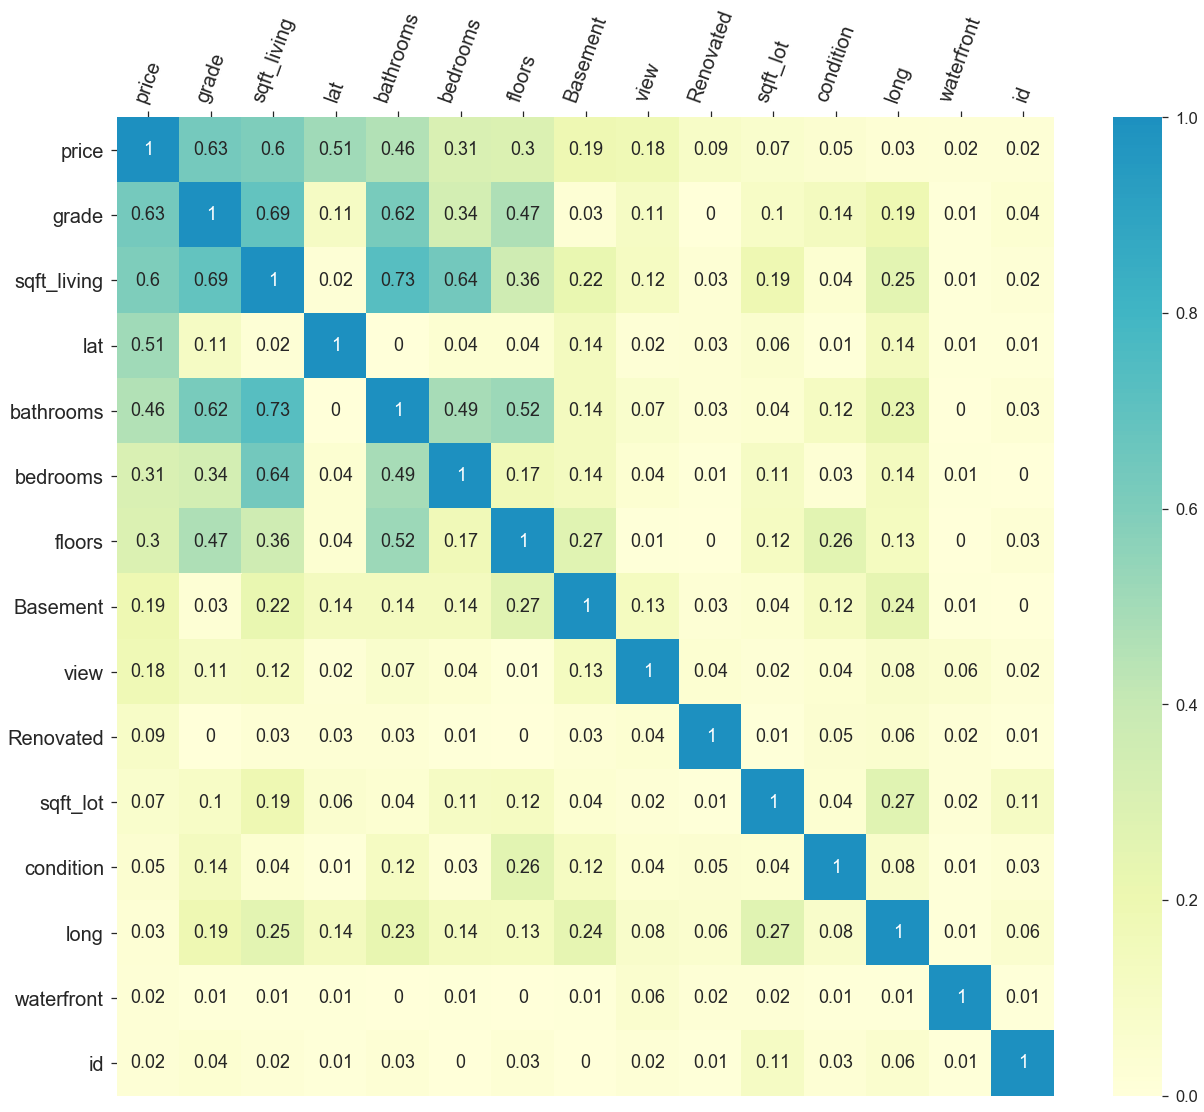

In [46]:
# displaying the heatmap for this notebook's original dataframe
plot_corr_heatmap(dls)

# Conclusion

* The final model is capable of explaining between 67 and 69\% of the variance in prices for homes in the King County data set.
* The strongest predictor, with a coefficient of 0.4556, is `grade`; the weakest is `Basement`, with a coefficient of 0.0041. We gain those insights with a caveat:
    * Having log transformed our target variable, 'price', along with 'sqft_living', 'condition', and 'grade' means the math is not as easy to interpret as it would be for data modeled in their original units.
    * Similaly, we complicated interpretation by min / max scaling  'sqft_living', 'condition', and 'grade'.
    * Scaling also affects the `condition number` reported in statsmodels, which can be helpful for identifying multicollinearity. Fortunately, cross - validating with sci - kit learn enables us to double - check our model's usefulness.
* We answered 4 of our 5 questions, along the way.
    * In consideration of time, question 2, concerning mean price within 20 miles of the (Seattle) city center, will have to be undertaken as a follow - on activity.
    * Using the central business district's 98101 zip code or the Space Needle observation tower coordinates of 47.6204°N 122.3491°W, we should be able to work out an answer to question 2 using a folium map similar to the one we created to locate 'null `waterfront`' homes.

In [47]:
data_drops_df.loc[data_drops_df['bedrooms']==2]['price'].mode()

0    325000.0
dtype: float64

> __The housing market is expensive, in the Seattle area.__
* Most two - bedroom homes are priced around 325K.
* In recent years it has gained a reputation as a hub for data and information workers. Although many workers in such fields earn well above national poverty - level wages, Payscale notes that the cost of living is 49\% higher than the national average.
* If you are looking for a starter - home to grow into, be prepared to commute.